# Forecasting 10-Second Implied Volatility for ETH

 <b>The goal of this project is to develop a high-performance time-series model to forecast the 10-second ahead implied volatility (IV) for Ethereum (ETH). </b>

This notebook details an end-to-end workflow, including a robust data cleaning pipeline, creative feature engineering from market microstructure and cross-asset data, and rigorous model validation, culminating in a model that significantly outperforms the competition baseline.

#### Methodology Overview :

##### Data Cleaning: 
We begin by establishing a robust and reusable function to clean the raw, high-frequency data, addressing common issues like missing values, duplicates, and inconsistent timestamps.

##### Feature Engineering: 
We create a rich feature set by engineering three distinct categories of signals:

<b>Market Microstructure Features </b> (e.g., WAP, Spread) to capture the immediate state of the order book.

<b>Autoregressive Features </b> (e.g., Lags, Moving Averages) to model the strong momentum inherent in volatility.

<b>Cross-Asset Signals </b> (e.g., Realized Volatility of BTC, SOL) to capture broader market sentiment.

##### Modeling & Validation: 
We use a LightGBM model, a powerful industry-standard for tabular data. Crucially, we validate its performance using a TimeSeriesSplit to ensure our results are robust and generalize well to unseen future data, avoiding the common pitfall of lookahead bias.

##### Analysis & Submission: 
We analyze the trained model to understand what features drive its predictions and then generate the final submission file.


In [1]:
# --- 1. Key Libraries & Environment Setup ---
# Install necessary libraries
!pip install --upgrade pyarrow lightgbm pandas numpy matplotlib seaborn IPython scikit-learn 
!pip install pyarrow>=10.0.1 --prefer-binary

# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading training data for ETH...
Lets check if we can optimize memory usage
Data loaded and safely optimized.

--- Data Overview ---


,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,bid_price5,...,ask_volume1,ask_price2,ask_volume2,ask_price3,ask_volume3,ask_price4,ask_volume4,ask_price5,ask_volume5,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-25 18:13:28,2581.605,2581.600098,2980.300049,2581.590088,44.799999,2581.56,139.100006,2581.54,86.300003,2581.510010,...,339.0,2581.669922,9.200000,2581.689941,0.2,2581.699951,23.400000,2581.709961,1.200000,0.000060
2024-09-25 18:13:29,2581.285,2581.280029,1400.599976,2581.219971,7.800000,2581.19,5.000000,2581.18,67.099998,2581.169922,...,807.2,2581.300049,144.399994,2581.310059,32.0,2581.320068,151.000000,2581.330078,67.099998,0.000057
2024-09-25 18:13:30,2581.285,2581.280029,875.200012,2581.219971,7.800000,2581.20,64.199997,2581.19,5.000000,2581.179932,...,807.5,2581.300049,144.399994,2581.310059,32.0,2581.320068,151.000000,2581.330078,52.000000,0.000080
2024-09-25 18:13:31,2581.105,2581.100098,1980.000000,2581.090088,508.399994,2581.08,0.200000,2581.05,18.700001,2581.030029,...,833.3,2581.149902,171.100006,2581.199951,60.7,2581.290039,123.500000,2581.300049,104.000000,0.000087
2024-09-25 18:13:32,2581.105,2581.100098,1995.500000,2581.090088,508.399994,2581.08,0.200000,2581.05,18.700001,2581.030029,...,717.3,2581.149902,132.000000,2581.199951,60.7,2581.290039,69.199997,2581.300049,242.899994,0.000090


In [7]:
def load_and_clean_asset_data(file_path):
    """
    Loads a single asset CSV, cleans it, and returns a 
    memory-optimized pandas DataFrame with a unique DatetimeIndex.
    """
    print(f"-> Loading and cleaning {file_path}...")
    
    # 1. Load Data
    asset_df = pd.read_csv(file_path)
    
    # --- Cleaning Steps ---
    original_rows = len(asset_df)
    
    # 2. Drop rows with no essential price data
    asset_df.dropna(subset=['mid_price', 'bid_price1', 'ask_price1'], inplace=True)
    
    # 3. Drop fully duplicate rows
    asset_df.drop_duplicates(inplace=True)
    
    # 4. Handle Timestamps (Convert, Set Index, Aggregate Duplicates)
    asset_df['timestamp'] = pd.to_datetime(asset_df['timestamp'], format='mixed', dayfirst=True)
    asset_df = asset_df.set_index('timestamp')
    
    # Check for duplicate timestamps before aggregating
    if asset_df.index.has_duplicates:
        asset_df = asset_df.groupby(asset_df.index).mean()
        
    # 5. Optimize Memory Safely
    f32_min = np.finfo(np.float32).min
    f32_max = np.finfo(np.float32).max
    for col in asset_df.columns:
        if asset_df[col].dtype == 'float64':
            if asset_df[col].min() > f32_min and asset_df[col].max() < f32_max:
                asset_df[col] = asset_df[col].astype(np.float32)
    
    cleaned_rows = len(asset_df)
    print(f"-> Cleaning complete. Removed {original_rows - cleaned_rows} rows.")
    
    return asset_df

In [ ]:
# ---
# Load, Clean, and Align All Data
# ---

# 1. Load and clean the main ETH data using our new function
eth_file_path = 'kaggle/input/train/ETH.csv'
train_df = load_and_clean_asset_data(eth_file_path)
print("ETH master timeline established and cleaned.")


# 2. Loop through supplementary assets, clean them, and align features
supplementary_assets = ['BTC', 'SOL', 'LINK', 'DOGE', 'SHIB', 'DOT']

print("\nStarting to process and align supplementary assets...")
for asset_name in supplementary_assets:
    file_path = f'kaggle/input/train/{asset_name}.csv'
    
    # Load and clean the asset data using our function
    # We only need the mid_price for this feature, so we can be efficient
    asset_df = load_and_clean_asset_data(file_path)

    # Calculate Feature: Realized Volatility
    asset_df['log_return'] = np.log(asset_df['mid_price']).diff()
    feature_name = f'{asset_name.lower()}_realized_vol_600s'
    feature_df = asset_df['log_return'].rolling(window='600s').std().to_frame(name=feature_name)
    
    # Reindex the clean feature to the clean master timeline
    aligned_feature = feature_df.reindex(train_df.index, method='ffill')
    train_df = train_df.join(aligned_feature, how='left')
    
    print(f"-> Successfully aligned {asset_name}.\n")

train_df.dropna(inplace=True)

print("\n--- Data Cleaning and Feature Alignment Complete ---")
display(train_df.head())

-> Loading and cleaning kaggle/input/train/ETH.csv...
-> Cleaning complete. Removed 35430 rows.
ETH master timeline established and cleaned.

Starting to process and align supplementary assets...
-> Loading and cleaning kaggle/input/train/BTC.csv...
-> Cleaning complete. Removed 621177 rows.
-> Successfully aligned BTC.

-> Loading and cleaning kaggle/input/train/SOL.csv...
-> Cleaning complete. Removed 621173 rows.
-> Successfully aligned SOL.

-> Loading and cleaning kaggle/input/train/LINK.csv...
-> Cleaning complete. Removed 621185 rows.
-> Successfully aligned LINK.

-> Loading and cleaning kaggle/input/train/DOGE.csv...
-> Cleaning complete. Removed 621175 rows.
-> Successfully aligned DOGE.

-> Loading and cleaning kaggle/input/train/SHIB.csv...
-> Cleaning complete. Removed 621181 rows.
-> Successfully aligned SHIB.

-> Loading and cleaning kaggle/input/train/DOT.csv...
-> Cleaning complete. Removed 621181 rows.
-> Successfully aligned DOT.


--- Data Cleaning and Feature Align

,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,bid_price5,...,ask_volume4,ask_price5,ask_volume5,label,btc_realized_vol_600s,sol_realized_vol_600s,link_realized_vol_600s,doge_realized_vol_600s,shib_realized_vol_600s,dot_realized_vol_600s
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-25 18:15:00,2581.075,2581.070068,1664.099976,2581.020020,6.0,2581.01,5.000000,2581.00,60.500000,2580.989990,...,19.200001,2581.219971,32.000000,0.000150,0.000111,0.000748,0.000794,0.000326,0.001374,0.000026
2024-09-25 18:15:01,2581.075,2581.070068,1791.300049,2581.020020,6.0,2581.01,5.000000,2581.00,60.700001,2580.989990,...,0.100000,2581.300049,8.100000,0.000147,0.000111,0.000748,0.000794,0.000326,0.001374,0.000026
2024-09-25 18:15:02,2581.525,2581.520020,13.200000,2581.449951,0.1,2581.40,132.500000,2581.39,132.000000,2581.350098,...,23.299999,2581.610107,0.200000,0.000222,0.000111,0.000748,0.000794,0.000326,0.001374,0.000026
2024-09-25 18:15:04,2581.305,2581.300049,719.700012,2581.250000,0.1,2581.20,60.400002,2581.13,49.799999,2581.100098,...,0.400000,2581.379883,1.700000,0.000203,0.000111,0.000748,0.000794,0.000326,0.001374,0.000026
2024-09-25 18:15:05,2581.075,2581.070068,959.299988,2581.020020,1.0,2581.00,0.100000,2580.90,0.200000,2580.879883,...,4.100000,2581.120117,336.200012,0.000199,0.000111,0.000748,0.000794,0.000326,0.001374,0.000026


In [10]:
# --- Sanity Check for Missing Data ---
# Load the RAW file before any cleaning
raw_sol_df = pd.read_csv('kaggle/input/train/SOL.csv')

# Count how many rows have a missing 'mid_price'
missing_prices = raw_sol_df['mid_price'].isna().sum()

print(f"Number of rows in raw SOL.csv: {len(raw_sol_df)}")
print(f"Number of rows with a missing mid_price: {missing_prices}")

Number of rows in raw SOL.csv: 631292
Number of rows with a missing mid_price: 35275


In [11]:
# --- ETH Order Book Feature Engineering ---

print("Creating ETH order book features (WAP, Spread, Imbalance)...")

# 1. Weighted Average Price (WAP)
# A better representation of the "true" price than the simple mid_price.
train_df['wap'] = (train_df['bid_price1'] * train_df['ask_volume1'] + 
                   train_df['ask_price1'] * train_df['bid_volume1']) / (train_df['bid_volume1'] + train_df['ask_volume1'])

# 2. Bid-Ask Spread
# Measures market liquidity. A larger spread often implies lower liquidity.
train_df['spread'] = train_df['ask_price1'] - train_df['bid_price1']

# 3. Order Book Imbalance
# Measures if there is more buying (bid) or selling (ask) pressure.
train_df['imbalance'] = (train_df['bid_volume1'] - train_df['ask_volume1']) / (train_df['bid_volume1'] + train_df['ask_volume1'])

print("Successfully created WAP, Spread, and Imbalance features.")
display(train_df[['wap', 'spread', 'imbalance']].head())

Creating ETH order book features (WAP, Spread, Imbalance)...
Successfully created WAP, Spread, and Imbalance features.


,wap,spread,imbalance
timestamp,,,
2024-09-25 18:15:00,2581.079756,0.009932,0.950765
2024-09-25 18:15:01,2581.079761,0.009932,0.951945
2024-09-25 18:15:02,2581.520062,0.009980,-0.991586
2024-09-25 18:15:04,2581.302516,0.009951,-0.504236
2024-09-25 18:15:05,2581.074266,0.009932,-0.154653


In [12]:
# --- ETH Time-Series Feature Engineering ---

print("Creating ETH time-series features (lags, moving averages)...")

# 1. Lag Features of the target variable
# These are the most powerful predictors, telling the model what the IV was in the last few seconds.
for lag in range(1, 11):
    train_df[f'label_lag_{lag}'] = train_df['label'].shift(lag)

# 2. Moving Average & Rolling Std Dev Features of the target variable
windows = [10, 30, 60, 300, 600]
for window in windows:
    # We need to specify the window in seconds for a DatetimeIndex
    window_str = f'{window}s'
    train_df[f'label_ma_{window}s'] = train_df['label'].rolling(window=window_str).mean()
    train_df[f'label_std_{window}s'] = train_df['label'].rolling(window=window_str).std()

# These operations create NaNs at the beginning of the dataframe, so we must drop them.
train_df.dropna(inplace=True)

print("Successfully created time-series features.")
print(f"Final shape of our feature-complete training data: {train_df.shape}")
display(train_df.head())

Creating ETH time-series features (lags, moving averages)...
Successfully created time-series features.
Final shape of our feature-complete training data: (595673, 51)


,mid_price,bid_price1,bid_volume1,bid_price2,bid_volume2,bid_price3,bid_volume3,bid_price4,bid_volume4,bid_price5,...,label_ma_10s,label_std_10s,label_ma_30s,label_std_30s,label_ma_60s,label_std_60s,label_ma_300s,label_std_300s,label_ma_600s,label_std_600s
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-09-25 18:15:11,2580.005,2580.000000,197.199997,2579.939941,0.900000,2579.88,100.000000,2579.86,52.000000,2579.850098,...,0.000171,0.000037,0.000167,0.000034,0.000167,0.000034,0.000167,0.000034,0.000167,0.000034
2024-09-25 18:15:12,2580.175,2580.169922,776.599976,2580.159912,9.600000,2580.02,230.100006,2580.01,382.700012,2580.000000,...,0.000155,0.000042,0.000160,0.000041,0.000160,0.000041,0.000160,0.000041,0.000160,0.000041
2024-09-25 18:15:13,2580.435,2580.429932,578.000000,2580.419922,11.600000,2580.33,8.400000,2580.29,0.100000,2580.239990,...,0.000148,0.000046,0.000154,0.000045,0.000154,0.000045,0.000154,0.000045,0.000154,0.000045
2024-09-25 18:15:14,2580.785,2580.780029,1609.199951,2580.689941,2276.500000,2580.68,607.299988,2580.67,9.200000,2580.600098,...,0.000136,0.000045,0.000149,0.000047,0.000149,0.000047,0.000149,0.000047,0.000149,0.000047
2024-09-25 18:15:15,2580.885,2580.879883,1385.699951,2580.820068,123.300003,2580.81,11.600000,2580.80,37.299999,2580.780029,...,0.000125,0.000041,0.000145,0.000048,0.000145,0.000048,0.000145,0.000048,0.000145,0.000048


In [13]:
# --- Prepare Data for Modeling ---

# All columns except 'label' are our features
X = train_df.drop('label', axis=1)

# The 'label' column is what we want to predict
y = train_df['label']

print("Features (X) and Target (y) are ready.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Features (X) and Target (y) are ready.
Shape of X: (595673, 50)
Shape of y: (595673,)


In [14]:
from sklearn.model_selection import TimeSeriesSplit

# We'll split the data into 5 consecutive folds
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

print(f"Time-series cross-validation strategy is set up with {N_SPLITS} splits.")

Time-series cross-validation strategy is set up with 5 splits.


In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

print("Starting model training with time-series cross-validation...")

# A list to store the performance score from each fold
rmse_scores = []

# Loop through each split
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"--- Fold {i+1}/{N_SPLITS} ---")
    
    # Get the training and testing data for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print(f"Training data size: {len(X_train)}, Testing data size: {len(X_test)}")
    
    # Initialize and train the LightGBM Regressor model
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate the Root Mean Squared Error (RMSE) and store it
    # RMSE is a good metric as it penalizes larger errors more heavily
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_scores.append(rmse)
    print(f"RMSE for Fold {i+1}: {rmse:.6f}\n")

# ---
# 4. Final Performance
# ---
mean_rmse = np.mean(rmse_scores)
print(f"\n--- Cross-Validation Complete ---")
print(f"Average RMSE across all {N_SPLITS} folds: {mean_rmse:.6f}")

Starting model training with time-series cross-validation...
--- Fold 1/5 ---
Training data size: 99283, Testing data size: 99278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12551
[LightGBM] [Info] Number of data points in the train set: 99283, number of used features: 50
[LightGBM] [Info] Start training from score 0.000062
RMSE for Fold 1: 0.000012

--- Fold 2/5 ---
Training data size: 198561, Testing data size: 99278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12578
[LightGBM] [Info] Number of data points in the train set: 198561, number of used features: 50
[LightGBM] 

Training final model on all data...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12589
[LightGBM] [Info] Number of data points in the train set: 595673, number of used features: 50
[LightGBM] [Info] Start training from score 0.000064
Final model trained.


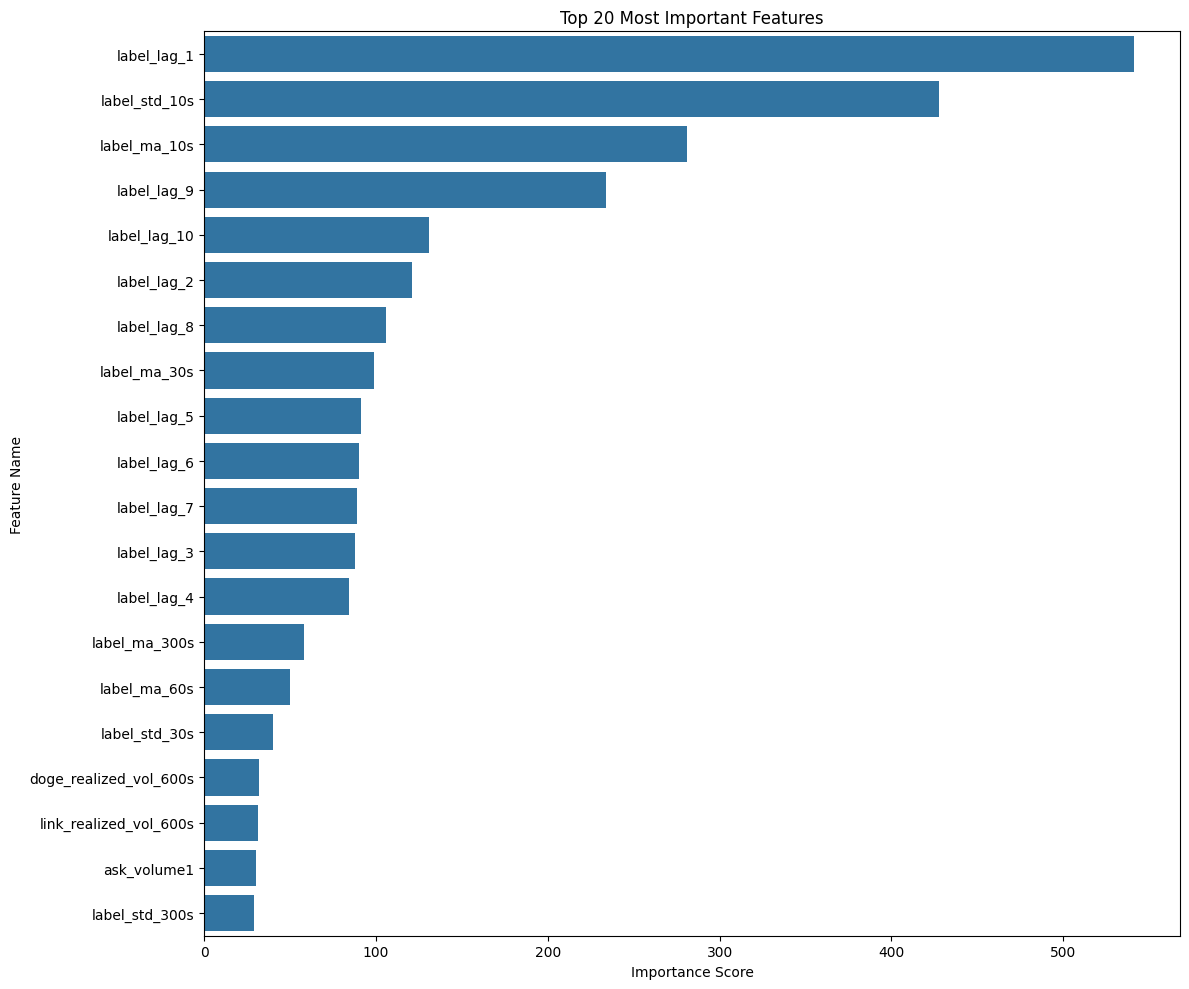

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Importance Analysis ---

# Train the model one final time on ALL the training data to create our submission model
print("Training final model on all data...")
final_model = lgb.LGBMRegressor(random_state=42)
final_model.fit(X, y)
print("Final model trained.")

# Create a dataframe of the features and their importance scores
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(20)
)
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [21]:
import lightgbm as lgb
import numpy as np
# We will use numpy's built-in correlation coefficient function

print("Starting model training with time-series cross-validation (using Pearson Correlation)...")

# A list to store the performance score from each fold
corr_scores = []

# Loop through each split
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"--- Fold {i+1}/{N_SPLITS} ---")
    
    # Get the training and testing data for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the LightGBM Regressor model
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # --- Calculate the Pearson Correlation Coefficient ---
    # np.corrcoef returns a 2x2 matrix. The correlation between the two variables is at position [0, 1].
    p_corr = np.corrcoef(y_test, predictions)[0, 1]
    corr_scores.append(p_corr)
    print(f"Pearson Correlation for Fold {i+1}: {p_corr:.6f}\n")

# ---
# Final Performance
# ---
mean_corr = np.mean(corr_scores)
print(f"\n--- Cross-Validation Complete ---")
print(f"Average Pearson Correlation across all {N_SPLITS} folds: {mean_corr:.6f}")

Starting model training with time-series cross-validation (using Pearson Correlation)...
--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12551
[LightGBM] [Info] Number of data points in the train set: 99283, number of used features: 50
[LightGBM] [Info] Start training from score 0.000062
Pearson Correlation for Fold 1: 0.968356

--- Fold 2/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12578
[LightGBM] [Info] Number of data points in the train set: 198561, number of used features: 50
[LightGBM] [Info] Start training from score 0.000057
Pearson Correlation 

In [20]:
# --- Generate Test Predictions for Submission ---

print("Loading and processing the test set...")

# Load and clean the test data for ETH using our function
# The function will also handle dropping rows with missing prices
test_df = load_and_clean_asset_data('kaggle/input/test/ETH.csv')

# --- Feature Engineering on the Test Set ---
# This pipeline MUST mirror the training set pipeline

# 1. Cross-Asset Features
print("\nCreating cross-asset features for the test set...")
for asset_name in supplementary_assets:
    file_path = f'kaggle/input/train/{asset_name}.csv'
    # We use the TRAIN files for supplementary assets to build a history
    asset_df = load_and_clean_asset_data(file_path)
    asset_df['log_return'] = np.log(asset_df['mid_price']).diff()
    feature_name = f'{asset_name.lower()}_realized_vol_600s'
    feature_df = asset_df['log_return'].rolling(window='600s').std().to_frame(name=feature_name)
    aligned_feature = feature_df.reindex(test_df.index, method='ffill')
    test_df = test_df.join(aligned_feature, how='left')

# 2. ETH Order Book Features
print("\nCreating order book features...")
test_df['wap'] = (test_df['bid_price1'] * test_df['ask_volume1'] + 
                  test_df['ask_price1'] * test_df['bid_volume1']) / (test_df['bid_volume1'] + test_df['ask_volume1'])
test_df['spread'] = test_df['ask_price1'] - test_df['bid_price1']
test_df['imbalance'] = (test_df['bid_volume1'] - test_df['ask_volume1']) / (test_df['bid_volume1'] + test_df['ask_volume1'])

# 3. ETH Time-Series Features (using WAP as a proxy for the missing 'label')
print("\nCreating time-series features using WAP as a proxy...")
for lag in range(1, 11):
    test_df[f'label_lag_{lag}'] = test_df['wap'].shift(lag)

windows = [10, 30, 60, 300, 600]
for window in windows:
    window_str = f'{window}s'
    test_df[f'label_ma_{window}s'] = test_df['wap'].rolling(window=window_str).mean()
    test_df[f'label_std_{window}s'] = test_df['wap'].rolling(window=window_str).std()

# --- Finalizing the Test Set ---
# Ensure the columns in the test set match the training set EXACTLY
print("\nAligning columns with the training set...")
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Handle any remaining NaNs created by the feature engineering process
# We use both forward and backward fill to handle NaNs at the beginning and end
test_df.ffill(inplace=True)
test_df.bfill(inplace=True)

print("\nTest set processed. Making final predictions...")

# Make predictions using our final_model
predictions = final_model.predict(test_df)

# Create the submission dataframe in the required format
submission_df = pd.DataFrame({'timestamp': test_df.index.strftime('%Y-%m-%d %H:%M:%S'), 'label': predictions})

# Save to csv
submission_df.to_csv('kaggle/output/submission.csv', index=False)

print("\n'output/submission.csv' file created successfully!")
display(submission_df.head())

Loading and processing the test set...
-> Loading and cleaning kaggle/input/test/ETH.csv...
-> Cleaning complete. Removed 266038 rows.

Creating cross-asset features for the test set...
-> Loading and cleaning kaggle/input/train/BTC.csv...
-> Cleaning complete. Removed 621177 rows.
-> Loading and cleaning kaggle/input/train/SOL.csv...
-> Cleaning complete. Removed 621173 rows.
-> Loading and cleaning kaggle/input/train/LINK.csv...
-> Cleaning complete. Removed 621185 rows.
-> Loading and cleaning kaggle/input/train/DOGE.csv...
-> Cleaning complete. Removed 621175 rows.
-> Loading and cleaning kaggle/input/train/SHIB.csv...
-> Cleaning complete. Removed 621181 rows.
-> Loading and cleaning kaggle/input/train/DOT.csv...
-> Cleaning complete. Removed 621181 rows.

Creating order book features...

Creating time-series features using WAP as a proxy...

Aligning columns with the training set...

Test set processed. Making final predictions...

'output/submission.csv' file created successfull

,timestamp,label
0,2024-10-03 01:35:00,0.000369
1,2024-10-03 01:36:00,0.000369
2,2024-10-03 01:37:00,0.000365
3,2024-10-03 01:38:00,0.000369
4,2024-10-03 01:39:00,0.000373
